# Logistic and linear regression with deterministic and stochastic first order methods

    TP 3 : Optimisation - DataScience Master
    Authors : Stéphane Gaiffas, Alexandre Gramfort
   
The aim of this TP is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 
The following methods are compared in this notebook.

**Batch (deterministic) methods**
- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2
$$
where
- $\ell(z, y) = \frac 12 (y - z)^2$ (least-squares regression)
- $\ell(z, y) = \log(1 + \exp(-yz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(\theta)
$$
where
$$
f_i(\theta) = \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(\theta) = (x_i^\top \theta - y_i) x_i + \lambda \theta
$$
and
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i x_i^\top \theta)} x_i + \lambda \theta.
$$

Denote by $L$ the Lipschitz constant of $f$ and by $L_i$ the Lipschitz constant of $f_i$. 
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{n} + \lambda \quad \text{ and } L_i = \| x_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| x_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / \max_{i=1,\ldots,n} L_i$

We now introduce a class that will be used for the solvers.

In [4]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.max(svd(self.A, full_matrices=False)[1]) ** 2 / self.n + self.lbda
        return L
    
    def lipschitz_constant_max(self):
        """Return max(Li)"""
        L_max =max([norm(self.A[i])**2 for i in range(self.n)])+ self.lbda
        return L_max

In [5]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.sum(np.max(self.A ** 2, axis=1)) / (4. * self.n) + self.lbda
        return L
    
    def lipschitz_constant_max(self):
        """Return max(Li)"""
        L_max =0.25*max([norm(self.A[i])**2 for i in range(self.n)])+ self.lbda
        return L_max

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [6]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz
  
def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [7]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    A, b = simu_linreg(x, n, std=std, corr=corr)
    return A, np.sign(b)

In [8]:
d = 50
n = 10000
idx = np.arange(d)


# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=0.7)


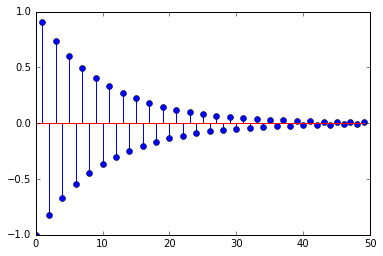

In [9]:
plt.stem(x_truth);

### Numerically check loss and gradient

In [10]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.3873711963760792e-06

In [11]:
lbda = 1. / n ** (0.5)
Al,bl=simu_logreg(x_truth,n)
model = LogReg(Al, bl, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

3.5222801058888595e-07

### Choice of the model

In [12]:
model = LinReg(A, b, lbda)
#model = LogReg(Al, bl, lbda)

### Compute the theoretical step-size for FISTA

In [13]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()


### Get a very precise minimum to compute distances to minimum

In [14]:
#x0
x_init=np.random.randn(50)
# Number of iterations
n_iter = 50

In [15]:
from scipy.optimize import fmin_l_bfgs_b

x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
print(f_min)

0.529931523366978


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BGFS)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [16]:
def inspector(loss_fun, x_real,x_min=x_min , f_min=f_min , verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Ista solver in the cell below

In [17]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x +=-step*grad(x)
        
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)

    return x

In [18]:
step = 1. / model.lipschitz_constant()
ista_inspector = inspector(model.loss, x_truth,x_min=x_min , f_min=f_min , verbose=True)
x_ista = ista(x_init, model.grad, n_iter,step , callback=ista_inspector)

   it    |   obj    |   err   
       0 | 9.51e+00 | 6.85e+00
      10 | 2.07e+00 | 3.99e+00
      20 | 7.71e-01 | 2.54e+00
      30 | 3.15e-01 | 1.67e+00
      40 | 1.36e-01 | 1.12e+00


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Fista solver in the cell below

In [19]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    x_new=x_init.copy()
    z = x_init.copy()
    t = 1.
    for k in range(n_iter):
        
        ### TODO
        x_new=z-step*grad(z)
        t_new=(1+np.sqrt(1+4*t**2))/2
        z=x_new+(t-1)/t_new*(x_new-x)
        t=t_new
        x=x_new.copy()

        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [20]:
step = 1. / model.lipschitz_constant()
fista_inspector = inspector(model.loss, x_truth,x_min=x_min , f_min=f_min , verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 9.51e+00 | 6.85e+00
      10 | 4.61e-01 | 2.02e+00
      20 | 2.35e-02 | 4.09e-01
      30 | 6.29e-03 | 2.39e-01
      40 | 2.33e-03 | 1.44e-01


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [21]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

cg_inspector = inspector(model.loss, x_truth,x_min=x_min , f_min=f_min , verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err   
       0 | 7.32e+00 | 6.40e+00
      10 | 1.81e-02 | 3.83e-01
      20 | 2.07e-05 | 1.17e-02
      30 | 3.42e-09 | 1.84e-04
Optimization terminated successfully.
         Current function value: 0.529932
         Iterations: 37
         Function evaluations: 65
         Gradient evaluations: 65


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [22]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

bfgs_inspector = inspector(model.loss, x_truth,x_min=x_min , f_min=f_min , verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err   
       0 | 1.11e+01 | 7.03e+00
      10 | 1.63e-02 | 3.36e-01
      20 | 1.33e-05 | 6.31e-03
      30 | 0.00e+00 | 0.00e+00


### A first numerical comparison of deterministic solvers

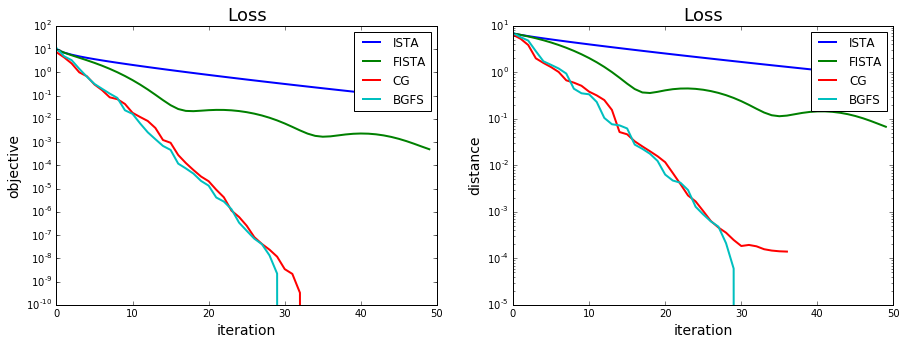

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

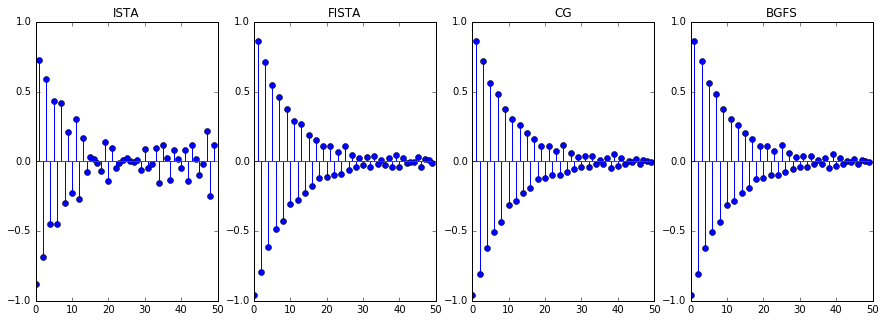

In [24]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about Fista, is it suprising ?

*ANSWERS*:

- ISTA needs more iteration to converge than the others.
- First we observe the usual bounces of FISTA (not a descent algorithm). Then, as expected, FISTA is faster that ISTA. We recall theoretically that FISTA is a O(1/t^2) whereas ISTA is a O(1/t). More intuitively, FISTA was desgined as an interpolation of the iterations of ISTA in order to be more efficient. We observe this fact.
- BFGS is a Quasi-Newton method. It means that it approximates second order information. For this reason, the convergence should be more precise that the three other methods. We observe this fact above. 


<a id='stoc'></a> 
## 4. Stochastic methods

In [25]:
iis = np.random.randint(0, n, n * n_iter)  


### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [26]:
np.random.seed(42)
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy() 
    for idx in range(n_iter):
        i = iis[idx]
        ### TODO
        x-=step*grad_i(i,x)/np.sqrt(idx+1)
        ### END TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x


In [27]:
step0 = 0.1
sgd_inspector = inspector(model.loss, x_truth, x_min=x_min , f_min=f_min ,verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err   
       0 | 1.76e+01 | 7.61e+00
      10 | 5.61e-03 | 9.46e-02
      20 | 2.75e-03 | 8.34e-02
      30 | 2.43e-03 | 7.28e-02
      40 | 2.04e-03 | 7.61e-02


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [28]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)

    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        y+=(grad_i(i,x)-gradient_memory[i].copy())/n
        gradient_memory[i]=grad_i(i,x)
        x-=step*y
        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x


In [29]:
step=1./model.lipschitz_constant_max()

sag_inspector = inspector(model.loss, x_truth,x_min=x_min , f_min=f_min , verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err   
       0 | 1.74e+01 | 7.57e+00
      10 | 3.85e-02 | 2.84e-01
      20 | 3.51e-04 | 2.75e-02
      30 | 1.27e-06 | 2.01e-03
      40 | 1.11e-08 | 2.00e-04


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [30]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x_tilde = x_init.copy()
    for idx in range(n_iter):
        
        if idx%n==0:
            x=x_tilde.copy()
            mu=grad(x)
            x_old=x.copy()
            
        i=iis[idx]
        x_old+=-step*(grad_i(i,x_old)-grad_i(i,x)+mu)    
        
        if (idx+1)%n==0:
            x_tilde=x_old.copy()
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x_old


In [31]:
step=1./model.lipschitz_constant_max()

svrg_inspector = inspector(model.loss, x_truth,x_min=x_min , f_min=f_min , verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err   
       0 | 1.74e+01 | 7.57e+00
      10 | 2.36e-06 | 2.20e-03
      20 | -2.82e-09 | 1.40e-04
      30 | -2.82e-09 | 1.40e-04
      40 | -2.82e-09 | 1.40e-04


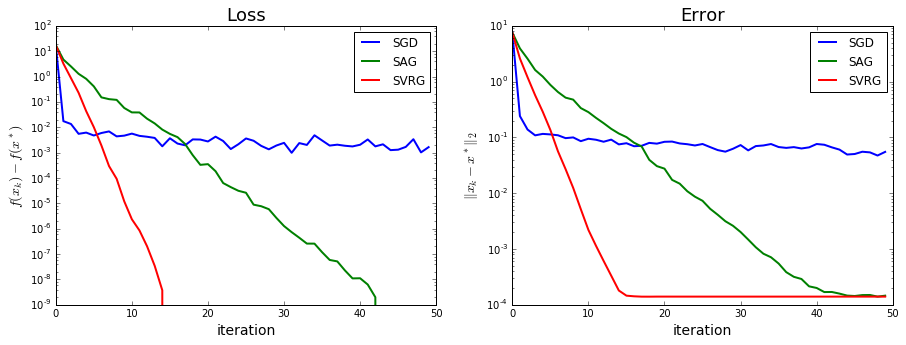

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

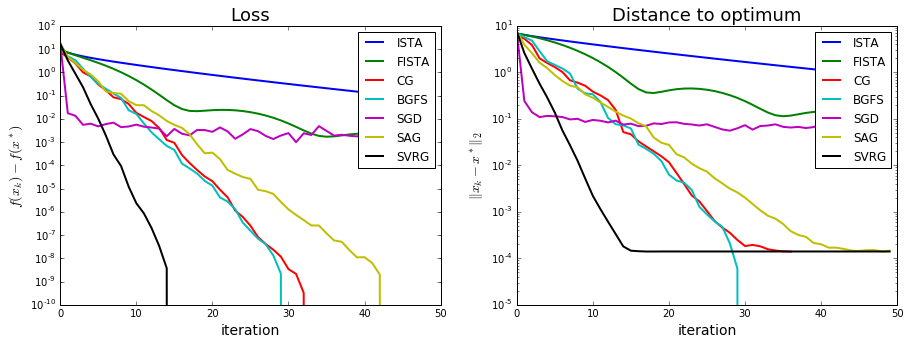

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

We observe that SGD is better than all for the first few iterations, then it fails to converge to a precise minimum. SVRG is the best for that (for this quite high level of correlation, we'll see below that it's no longer true when we decrease the level of correlation). FISTA and ISTA need much more iterations.

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

In [34]:
#function that run every algorithms for a given model, a given correlation, and a given lambda
def run_every_algorithms(x_truth,lbda=1./n**0.5,model_type="Linear",corr=0.7):
    
    if model_type=="Linear":
        A, b = simu_linreg(x_truth, n, std=1., corr=corr)
        model2 = LinReg(A, b, lbda)
    elif model_type=="Logistic":
        A, b = simu_logreg(x_truth, n, std=1., corr=corr)
        model2 = LogReg(A, b, lbda)

    x_min, f_min, _ = fmin_l_bfgs_b(model2.loss, x_init, model2.grad, pgtol=1e-20)
    
    #train ISTA
    step = 1. / model2.lipschitz_constant()
    ista_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)
    x_ista = ista(x_init, model2.grad, n_iter,step , callback=ista_inspector)
    #train FISTA
    step = 1. / model2.lipschitz_constant()
    fista_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)
    x_fista = fista(x_init, model2.grad, n_iter, step, callback=fista_inspector) #the step is the same for both models
    #train BFGS
    bfgs_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)
    x_bfgs, _, _ = fmin_l_bfgs_b(model2.loss, x_init, model2.grad, maxiter=n_iter, callback=bfgs_inspector)
    # CG
    cg_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)
    x_cg = fmin_cg(model2.loss, x_init, model2.grad, maxiter=n_iter, callback=cg_inspector)
    #SGD
    step0 = 0.1
    sgd_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)
    x_sgd = sgd(x_init, iis, model2.grad_i, n * n_iter, step=step0, callback=sgd_inspector)
    #SVRG
    step=1./model2.lipschitz_constant_max()
    svrg_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)    
    x_svrg = svrg(x_init, iis, model2.grad, model2.grad_i, n * n_iter,step, callback=svrg_inspector)
    #SAG
    sag_inspector = inspector(model2.loss, x_truth,x_min=x_min,f_min=f_min, verbose=False)
    x_sag = sag(x_init, iis, model2.grad_i, n * n_iter, step, callback=sag_inspector)
    
    inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
    sgd_inspector, sag_inspector, svrg_inspector]
    
    return(inspectors)


In [35]:
import matplotlib.gridspec as gridspec

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

#output all the convergence plots given the x_truth, lambda and correlation list that we want
def train_plot_all_algorithms(x_truth,lbda=1./n**0.5,model_type="Linear",corr_list=[0.7]):
    i=0
    inspector_list=[]
    for corr in corr_list:
        inspector_list.append(run_every_algorithms(x_truth,lbda,model_type=model_type,corr=corr))
    gs = gridspec.GridSpec(len(corr_list), 2)
    plt.figure(figsize=(15, 5*len(corr_list)))
    for inspector in inspector_list:
        plt.subplot(gs[i, 0])
        for insp in inspector:
            plt.plot(insp.obj, lw=2)
            plt.title("Loss with corr={},lambda={}".format(str(corr_list[i]),lbda), fontsize=18)
            plt.xlabel("iteration", fontsize=14)
            plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
            plt.yscale("log")
        plt.legend(solvers)
        plt.subplot(gs[i, 1])
        for insp in inspector:
            plt.plot(insp.err, lw=2)
            plt.title("Distance to optimum with corr={},lambda={}".format(str(corr_list[i]),lbda), fontsize=18)
            plt.xlabel("iteration", fontsize=14)
            plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
            plt.yscale("log")
        plt.legend(solvers);    
        i=i+1

Optimization terminated successfully.
         Current function value: 0.527958
         Iterations: 37
         Function evaluations: 64
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 0.489693
         Iterations: 39
         Function evaluations: 69
         Gradient evaluations: 69


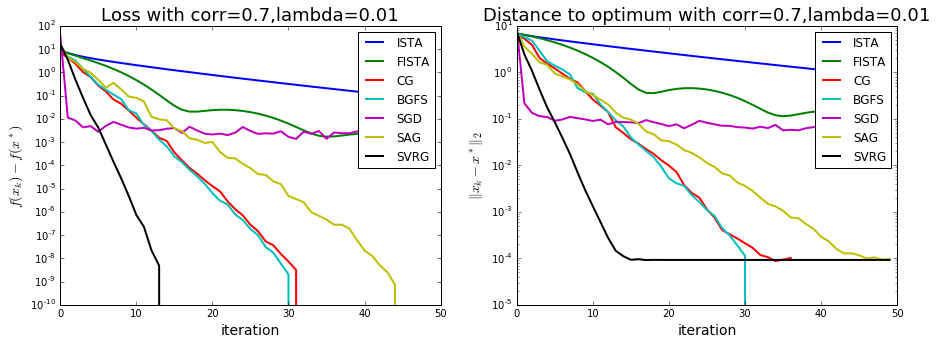

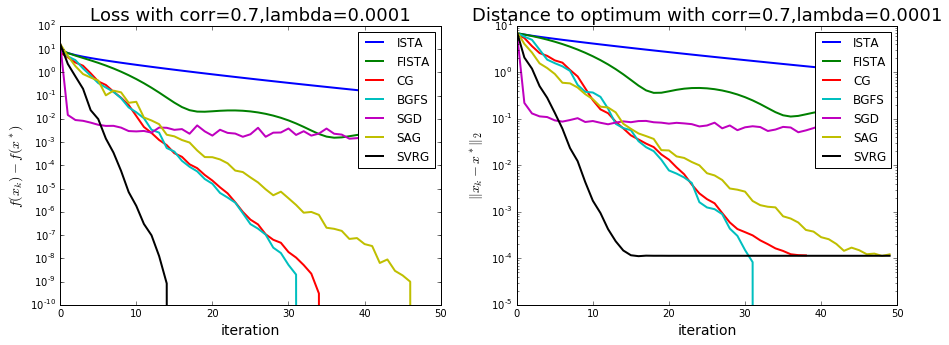

In [36]:
#changing the values of lambda from high to low penalization
train_plot_all_algorithms(x_truth,1/n**0.5)
train_plot_all_algorithms(x_truth,1/n)

As we can see the algorithms converge faster when lambda is big (high penalization), especially for CG and SAG. 

Optimization terminated successfully.
         Current function value: 0.524879
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.528210
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.517410
         Iterations: 34
         Function evaluations: 56
         Gradient evaluations: 56


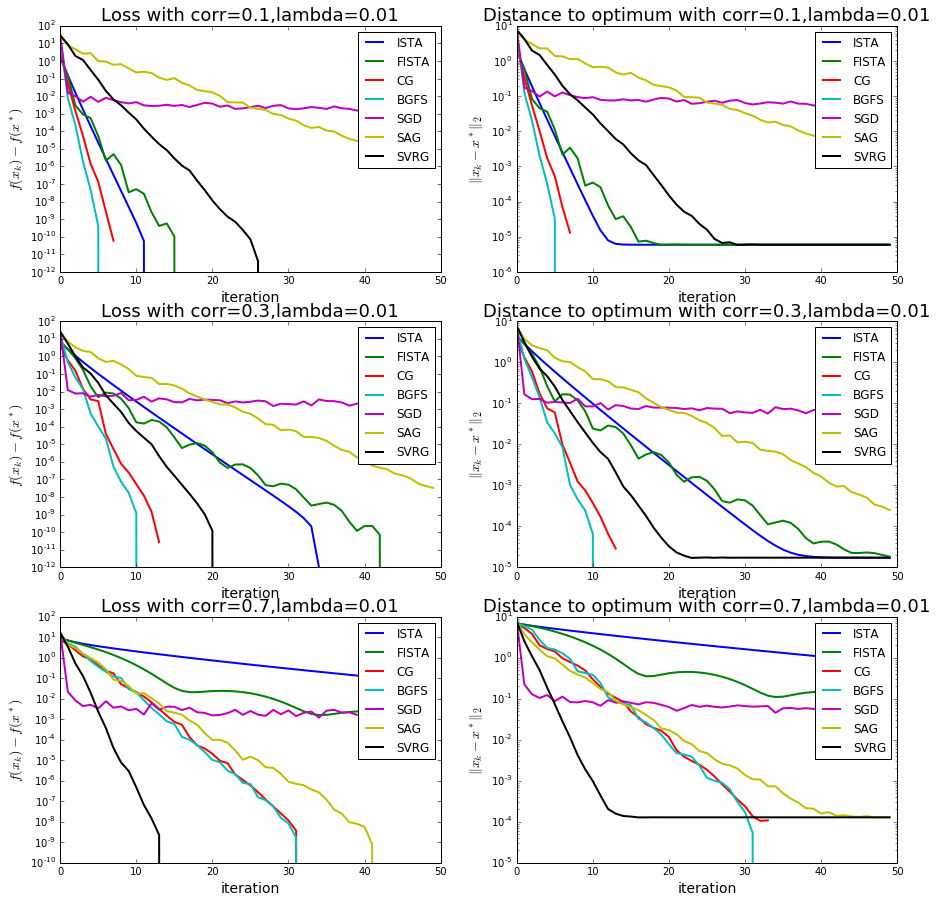

In [37]:
train_plot_all_algorithms(x_truth,lbda,"Linear",corr_list=[0.1,0.3,0.7])


         Current function value: 0.814319
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.399754
         Iterations: 14
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.517244
         Iterations: 29
         Function evaluations: 59
         Gradient evaluations: 59


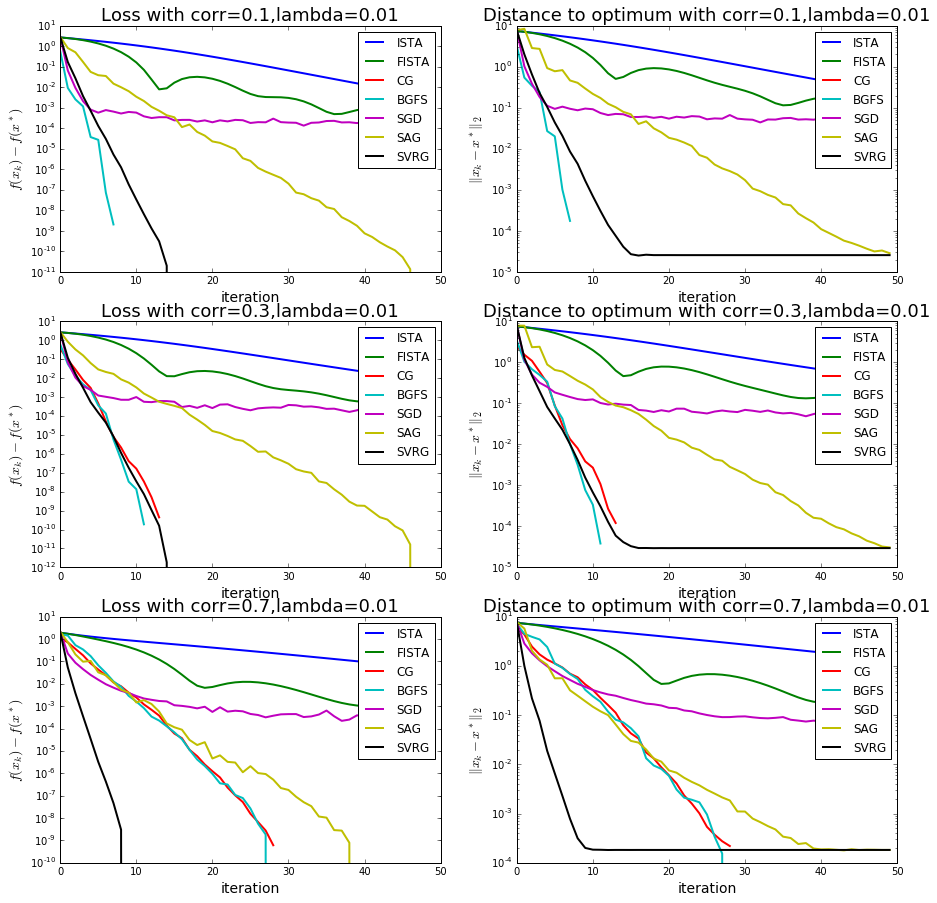

In [39]:
train_plot_all_algorithms(x_truth,lbda,"Logistic",corr_list=[0.1,0.3,0.7])

We observe a few interesting facts when we change the correlation

- The convergence is much faster when correlation is high for the stochastic algorithms SAG and SVRG. The effect is not so clear for SGD (much less impact).
- Conversely, the remaining algorithms are all much faster when correlation is low.
- The effect of correlation for ISTA and FISTA is much more visible with the Linear model.
- SAG and SVRG seem to give as precise solution as second order method like BFGS which is quite impressive


If we need a quick answer (few iterations, not so precise minimum) SGD is the best. Otherwise, it depends on the level of correlation between the features. SVRG tends to have better results, except when correlation level is low in which case CG or BGFS are better.